In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
slim = tf.contrib.slim

%matplotlib inline

In [2]:
# Create a multilayer perceptron regression model.
def regression_model(inputs, is_training = True, scope = "deep_regression"):
    with tf.variable_scope(scope, values = [inputs]):
        end_points = {}
        with slim.arg_scope([slim.fully_connected], 
                            activation_fn = tf.nn.relu,
                            weights_regularizer = slim.l2_regularizer(0.01)):
            # First fully connected layer.
            net = slim.fully_connected(inputs, 32, scope = "fc1")
            end_points["fc1"] = net
            # Dropout to prevent over-fitting.
            net = slim.dropout(net, 0.8, is_training = is_training)
            # Second fully connected layer.
            net = slim.fully_connected(net, 16, scope="fc2")
            end_points["fc2"] = net
            # Final fully connected layer without nonlinearity.
            predictions = slim.fully_connected(net, 1, activation_fn = None, scope = "prediction")
            end_points["out"] = predictions
            # Return all nodes.
            return predictions, end_points

In [3]:
# Print the name and shape of the model.
with tf.Graph().as_default():
    # Dummy placeholders for inputs and outputs.
    inputs = tf.placeholder(tf.float32, shape=(None, 1))
    outputs = tf.placeholder(tf.float32, shape=(None, 1))
    # Build model.
    predictions, end_points = regression_model(inputs)
    # Print name and shape for each tensor.
    print "Layers"
    for k,v in end_points.iteritems():
        print "name = {}, shape = {}".format(v.name, v.get_shape())
    # Print name and shape for parameter nodes.
    print "\n"
    print "Parameters"
    for v in slim.get_model_variables():
        print "name = {}, shape = {}".format(v.name, v.get_shape())

Layers
name = deep_regression/fc1/Relu:0, shape = (?, 32)
name = deep_regression/fc2/Relu:0, shape = (?, 16)
name = deep_regression/prediction/BiasAdd:0, shape = (?, 1)


Parameters
name = deep_regression/fc1/weights:0, shape = (1, 32)
name = deep_regression/fc1/biases:0, shape = (32,)
name = deep_regression/fc2/weights:0, shape = (32, 16)
name = deep_regression/fc2/biases:0, shape = (16,)
name = deep_regression/prediction/weights:0, shape = (16, 1)
name = deep_regression/prediction/biases:0, shape = (1,)


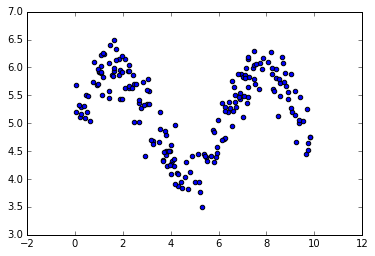

In [4]:
# Generate 1d regression data: y = sin(x) + 5 + noise.
def produce_batch(batch_size, noise = 0.3):
    xs = np.random.random(size = [batch_size, 1]) * 10
    ys = np.sin(xs) + 5 + np.random.normal(size = [batch_size, 1], scale=noise)
    return [xs.astype(np.float32), ys.astype(np.float32)]

x_train, y_train = produce_batch(200)
x_test, y_test = produce_batch(200)
plt.scatter(x_train, y_train)

In [5]:
# Train model with l2 loss.
def convert_data_to_tensors(x, y):
    inputs = tf.constant(x)
    inputs.set_shape([None, 1])
    outputs = tf.constant(y)
    outputs.set_shape([None, 1])
    return inputs, outputs

ckpt_dir = "regression_model/"
with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    inputs, targets = convert_data_to_tensors(x_train, y_train)
    predictions, nodes = regression_model(inputs, is_training=True)
    l2_loss = slim.losses.mean_squared_error(predictions, targets)
    optimizer = tf.train.AdamOptimizer(learning_rate = 0.005)
    train_op = slim.learning.create_train_op(l2_loss, optimizer)
    final_loss = slim.learning.train(train_op,
                                     logdir = ckpt_dir,
                                     number_of_steps = 5000,
                                     save_summaries_secs = 5,
                                     log_every_n_steps = 500)

INFO:tensorflow:Starting Session.
INFO:tensorflow:Starting Queues.
INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:global step 500: loss = 0.3018 (0.00 sec/step)
INFO:tensorflow:global step 1000: loss = 0.2980 (0.00 sec/step)
INFO:tensorflow:global step 1500: loss = 0.2738 (0.00 sec/step)
INFO:tensorflow:global step 2000: loss = 0.2552 (0.00 sec/step)
INFO:tensorflow:global step 2500: loss = 0.2553 (0.00 sec/step)
INFO:tensorflow:global step 3000: loss = 0.2470 (0.00 sec/step)
INFO:tensorflow:global step 3500: loss = 0.2509 (0.00 sec/step)
INFO:tensorflow:global step 4000: loss = 0.2315 (0.00 sec/step)
INFO:tensorflow:global step 4500: loss = 0.2268 (0.00 sec/step)
INFO:tensorflow:global step 5000: loss = 0.1386 (0.00 sec/step)
INFO:tensorflow:Stopping Training.
INFO:tensorflow:Finished training! Saving model to disk.


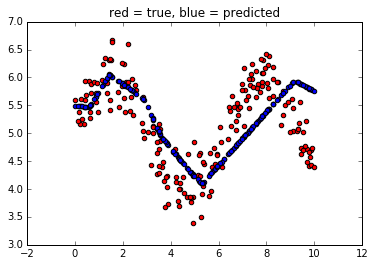

In [6]:
# Load saved model and use for prediction.
with tf.Graph().as_default():
    inputs, targets = convert_data_to_tensors(x_test, y_test)
    predictions, end_points = regression_model(inputs, is_training=False)
    sv = tf.train.Supervisor(logdir = ckpt_dir)
    with sv.managed_session() as sess:
        inputs, predictions, targets = sess.run([inputs, predictions, targets])
        
        
plt.scatter(inputs, targets, c = 'r')
plt.scatter(inputs, predictions, c = 'b')
plt.title("red = true, blue = predicted")